In [83]:
import numpy as np
import matplotlib.pyplot as plt
#import composite
%matplotlib inline
from numpy import trapz
import spectral_analysis as sa
import kaepora as kpora
import kaepora_plot as kplot
import add_new_columns as anc
import matplotlib as mpl
import kyle_functions as kf
import composite as composite
import copy
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, MaxNLocator

In [9]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

# This is just a query that I will compare my automated binning to

In [ ]:
query_strings_highv = ["SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < -10. and ((dm15_source >= 1.0 and dm15_source < 1.3) or (dm15_from_fits >= 1.0 and dm15_from_fits < 1.3)) and (si_v0 between -30000 and -12000)"]
max_phase = 71.
p1 = -10.
k = 3.
#p2 = p1+k
while p1 < max_phase:
    if 32 >= p1 > 20.:
        k = 6.
    if p1 >32:
        k = 9.
    p2 = p1+k
    #p2 += k
    
    #print (p1,p2)
    query_strings_highv.append("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase >= %f and phase < %f and ((dm15_source >= 1.0 and dm15_source < 1.3) or (dm15_from_fits >= 1.0 and dm15_from_fits < 1.3)) and (si_v0 between -30000 and -12000)"% (p1,p2))
    p1 += k

        
for q in query_strings_highv:
    print q

In [ ]:
composites_highv, sn_arrays_highv, boot_sn_arrays_highv = kpora.make_composite(query_strings_highv, boot=False, medmean=1, verbose=False, gini_balance=True, combine=True)

# AUTOMATED DM15 BINNING

In [2]:
test_query = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 50. and ((dm15_source >= 1.0 and dm15_source < 1.3) or (dm15_from_fits >= 1.0 and dm15_from_fits < 1.3)) and (si_v0 between -30000 and -12000)"
SN_Array = composite.grab(test_query, multi_epoch = True, make_corr = True, selection = "max_coverage")

579 Total Spectra found
8 flagged spectra removed 571 spectra left
0 spectra of peculiar Ias removed 571 spectra left
571 spectra of SNe that have host reddening corrections
Arrays cleaned


In [10]:
def make_composite(SN_Array, boot=False, medmean=1, make_corr=True, multi_epoch=False,
                  selection='max coverage', gini_balance=False, aggro=.5, verbose=True,
                  low_av_test=None, combine=True, get_og_arr=False):
    
    SN_Array_new = copy.deepcopy(SN_Array)
    SN_Array_new = composite.prelim_norm(SN_Array_new)
    SN_Array_new = composite.fix_negative_ivars(SN_Array_new)
    og_SN_Array = copy.deepcopy(SN_Array_new)
    
    if combine:
        SN_Array_new = composite.combine_SN_spectra(SN_Array_new)
        

    if make_corr == True:
        av_cutoff=2.
        SN_Array_new = composite.apply_host_corrections(SN_Array_new, verbose=verbose, cutoff=av_cutoff)
        og_SN_Array = composite.apply_host_corrections(og_SN_Array, verbose=False, cutoff=av_cutoff)
    #print 'removed spectra of SNe with A_V >', av_cutoff
    
    SN_Array_new = composite.prelim_norm(SN_Array_new)

    
    wave_ranges = []
    for spectrum in SN_Array_new:
        wave_range = spectrum.wavelength[spectrum.x2] - spectrum.wavelength[spectrum.x1]
        wave_ranges.append(wave_ranges)
    
    template = SN_Array_new[wave_ranges.index(max(wave_ranges))]
    template.spec_bin = composite.spectra_per_bin(SN_Array_new)
    
    new_composite_spectrum, boot_array = composite.create_composite(SN_Array_new, boot, template=template, medmean=1, gini_balance=True)
    
    #kpora.set_min_num_spec([composite_spectrum], 3)
    #kplot.comparison_plot([composite_spectrum], scale_type=False, min_num_show=3)
    
    if boot == False:
        return new_composite_spectrum
    
    elif boot == True:
        return new_composite_spectrum, boot_array

In [11]:
# sort a query by phase
def phase_sort(spectra):
    sorted_spectra = []
    
    phase_dict = {}
    phase_list = []
    for spectrum in spectra:
        phase_dict[spectrum.phase] = spectrum
        phase_list.append(spectrum.phase)
        
    phase_list = np.asarray(phase_list)
    sorted_phases = np.sort(phase_list)
    
    for phase in sorted_phases:
        sorted_spectra.append(phase_dict[phase])
        
    return sorted_spectra

In [12]:
def dm15_arrange(spectra, n_min=3, n_max=5):
    
    """Takes a list of phase-sorted spectral objects and sorts them into bins that will create composites
    with most similar dm15
    
    INPUTS:
    spectra : a list of queried spectral objects sorted by phase
    n_min : a minimum amount of objects per bin
    n_max : a maximum amount of objects per bin
    
    OUTPUTS:
    composites : list of bins of spectra to be used to create composites
    """
    dm15_list = []
    for spectrum in spectra:
        dm15_list.append(spectrum.dm15)
   
    #find the ideal dm15
    dm15_ideal = np.median(dm15_list) 
    
    bins = []
    
    i = 0
    
    while i + n_max < len(spectra):
        
        
        #loop to test dm15 for bin size between 3 and 5
        
        dm15_avgs = [] #list of dm15 averages for bins between from spectrum i to i+n
        for n in range(n_min, n_max+1):
    
            bin_sample = []
            for m in range(i, i+n):
                #print(m)
                bin_sample.append(dm15_list[m])
                
            dm15_avg = np.mean(bin_sample)
            bin_size = len(bin_sample)
            dm15_avgs.append([dm15_avg, bin_size])
            
        
        difs = []
        for avg in dm15_avgs:
            dif_sqr = (avg[0] - dm15_ideal)**2
            difs.append(dif_sqr)
            
        
        best_avg = dm15_avgs[difs.index(min(difs))]
        
        
        bins.append(spectra[i: i+best_avg[1]])
        
        i = i + best_avg[1]
        
    return bins

In [13]:
'''def maxphase(phase_0):
    if phase_0 < 10:
        mp = phase_0 + 3
    elif 10 <= phase_0 < 30:
        mp = phase_0 + 5
    elif 30 <= phase_0 < 50:
        mp = phase_0 + 7
    elif 50 <= phase_0 < 80:
        mp = phase_0 + 10
    elif 80 <= phase_0 < 110:
        mp = phase_0 + 15
    elif 110 <= phase_0 < 150:
        mp = phase_0 + 30
    elif 150 <= phase_0:
        mp = phase_0 + 80
    
    #return mp"""
    #mp = phase_0 + 2
    return mp'''

'def maxphase(phase_0):\n    if phase_0 < 10:\n        mp = phase_0 + 3\n    elif 10 <= phase_0 < 30:\n        mp = phase_0 + 5\n    elif 30 <= phase_0 < 50:\n        mp = phase_0 + 7\n    elif 50 <= phase_0 < 80:\n        mp = phase_0 + 10\n    elif 80 <= phase_0 < 110:\n        mp = phase_0 + 15\n    elif 110 <= phase_0 < 150:\n        mp = phase_0 + 30\n    elif 150 <= phase_0:\n        mp = phase_0 + 80\n    \n    #return mp"""\n    #mp = phase_0 + 2\n    return mp'

In [14]:
def maxphase(phase_0):
    if phase_0 < 0:
        mp =  3
    elif 0 <= phase_0 < 4:
        mp = 1
    elif 4 <= phase_0 < 10:
        mp = 2
    elif 10 <= phase_0 < 30:
        mp =  5
    elif 30 <= phase_0 < 50:
        mp = 7
    elif 50 <= phase_0 < 80:
        mp = 10
    elif 80 <= phase_0 < 110:
        mp = 15
    elif 110 <= phase_0 < 150:
        mp = 30
    elif 150 <= phase_0:
        mp = 80
    
    #return mp"""
    #mp = phase_0 + 2
    return mp

In [15]:
'''def dm15_arrange1(spectra, n_min=3):
    
    """Takes a list of phase-sorted spectral objects and sorts them into bins that will create composites
    with most similar dm15
    
    INPUTS:
    spectra : a list of queried spectral objects sorted by phase
    n_min : a minimum amount of objects per bin
    
    OUTPUTS:
    composites : list of bins of spectra to be used to create composites
    """
    dm15_list = []
    for spectrum in spectra:
        dm15_list.append(spectrum.dm15)
   
    #find the ideal dm15
    dm15_ideal = np.median(dm15_list) 
    
    bins = []
    i = 0
    
    while i < len(spectra):
        print i
        bin = []
        mp = maxphase(spectra[i].phase)
        
        for spectrum in spectra[i:]:
            if spectrum.phase <= mp:
                bin.append(spectrum)
                i = i + 1
        
        if len(bin) < n_min:
            print 
            #print "Only " + str(len(bin)) + " spectra found from " + str(spectra[i].phase) + " to " + str(spectra[i].phase+mp) 
        bins.append(bin) 
    return bins'''
            

'def dm15_arrange1(spectra, n_min=3):\n    \n    """Takes a list of phase-sorted spectral objects and sorts them into bins that will create composites\n    with most similar dm15\n    \n    INPUTS:\n    spectra : a list of queried spectral objects sorted by phase\n    n_min : a minimum amount of objects per bin\n    \n    OUTPUTS:\n    composites : list of bins of spectra to be used to create composites\n    """\n    dm15_list = []\n    for spectrum in spectra:\n        dm15_list.append(spectrum.dm15)\n   \n    #find the ideal dm15\n    dm15_ideal = np.median(dm15_list) \n    \n    bins = []\n    i = 0\n    \n    while i < len(spectra):\n        print i\n        bin = []\n        mp = maxphase(spectra[i].phase)\n        \n        for spectrum in spectra[i:]:\n            if spectrum.phase <= mp:\n                bin.append(spectrum)\n                i = i + 1\n        \n        if len(bin) < n_min:\n            print \n            #print "Only " + str(len(bin)) + " spectra found from "

In [16]:
def dm15_arrange1(spectra, n_min=5):
    
    """Takes a list of phase-sorted spectral objects and sorts them into bins that will create composites
    with most similar dm15
    
    INPUTS:
    spectra : a list of queried spectral objects sorted by phase
    n_min : a minimum amount of objects per bin
    
    OUTPUTS:
    composites : list of bins of spectra to be used to create composites
    """
    dm15_list = []
    for spectrum in spectra:
        dm15_list.append(spectrum.dm15)
   
    #find the ideal dm15
    dm15_ideal = np.median(dm15_list) 
    
    event_bins = []
    bins = []
    i = 0
    
    
    while i < len(spectra):
        #print i
        bin = []
        event_bin = []
        
        #print spectra[i:][0].phase
        mp = maxphase(spectra[i:][0].phase)
        lookahead = spectra[i:][0].phase + mp
        lookahead2 = spectra[i:][0].phase + 2*mp
        
        for spectrum in spectra[i:]:
            #print lookahead
            if spectrum.phase <= lookahead:
                #print spectrum.phase, 'yes'
                bin.append(spectrum)
                if spectrum.name not in event_bin:
                    event_bin.append(spectrum.name)
                i = i + 1
        print "original", len(event_bin), len(bin)
        
        #print len(event_bin)<n_min
        
        if len(event_bin) < n_min: #block to describe what to do when not enough data in bin
            for spectrum in spectra[i:]:
                if spectrum.phase <= lookahead2 and spectrum not in bin:
                    bin.append(spectrum)
                    if spectrum.name not in event_bin:
                        event_bin.append(spectrum.name)
                    i = i + 1
            print "expanded", len(event_bin), len(bin)
        
            #print "Only " + str(len(bin)) + " spectra found from " + str(spectra[i].phase) + " to " + str(spectra[i].phase+mp) 
        
        if len(event_bin) >= n_min:
            event_bins.append(event_bin)
            bins.append(bin) 
        
        else:
            print "not enough data (" + str(len(event_bin)) + ") between " + str(bin[0].phase) + " and " + str(lookahead2) + " days."
    
    #print [len(bin) for bin in bins]
    #print [len(event_bin) for event_bin in event_bins]
    
    return bins

# TESTING

In [ ]:
sorted_SN_Array = phase_sort(SN_Array)
bins = dm15_arrange1(sorted_SN_Array, 5)

In [ ]:
#creating a list of composite spectra

composite_spectra = []

for bin in bins:
    wave_ranges = []
    for spectrum in bin:
        wave_range = spectrum.wavelength[spectrum.x2] - spectrum.wavelength[spectrum.x1]
        wave_ranges.append(wave_ranges)
    
    template = bin[wave_ranges.index(max(wave_ranges))]
    template.spec_bin = composite.spectra_per_bin(bin)
    
    composite_spectrum = composite.create_composite(bin, boot='False', template=template, medmean=1)
    composite_spectra.append(composite_spectrum[0])
    
    #kplot.plot_comp_and_all_spectra(composite_spectrum[0], bin, dm15=True)

dm15 for each bin in my automated sample

In [ ]:
dm15_dist = []
phase_dist = []
for composite_spectrum in composite_spectra:    
    #print composite_spectrum.dm15, composite_spectrum.phase
    dm15_dist.append(np.mean(composite_spectrum.dm15_array[composite_spectrum.x1:composite_spectrum.x2]))
    phase_dist.append(np.mean(composite_spectrum.phase_array[composite_spectrum.x1:composite_spectrum.x2]))
    
print dm15_dist

plt.hist(dm15_dist)
plt.show()
plt.plot(phase_dist, dm15_dist, 'o')
plt.show()

dm15 for each bin in my comparison sample

In [ ]:
'''for composite_spectrum in composite_spectra:
    #print composite_spectrum.spec_bin
    kpora.set_min_num_spec([composite_spectrum], 1)
    kplot.comparison_plot([composite_spectrum], scale_type=False, min_num_show=3)
    #i want to be able to do this with proper gini weighting instead of just taking the median
    '''

In [ ]:
new_composites = []
for bin in bins:
    new_composite = make_composite(bin)
    new_composite_dm15 = np.mean(new_composite.dm15_array[new_composite.x1:new_composite.x2])
    print new_composite_dm15
    new_composites.append(new_composite)

"""for new_composite in new_composites:
    kpora.set_min_num_spec([new_composite], 3)
    kplot.comparison_plot([new_composite], scale_type=False, min_num_show=3)"""

In [ ]:
for i in range(len(new_composites)):
    kplot.comparison_plot([new_composites[i]], scale_type=False, min_num_show=3)

# Sample Time Series

In [ ]:
len(new_composites)

In [ ]:
plt.figure(figsize = (10,10))
plt.title("v0 > 12000 and 1.0 < dm15 < 1.3 Time Series")
#plt.xlim((3000,9500))
#plt.ylim((6.5,22))
#plt.yticks([])
#plt.tick_params(axis='y',which='both', bottom=False, top=False)

offset = 10*len(new_composites)
for n in range(len(new_composites)):
    phase = np.mean(new_composites[n].phase_array[new_composites[n].x1:new_composites[n].x2])
    dm15 = np.mean(new_composites[n].dm15_array[new_composites[n].x1:new_composites[n].x2])
    
    plt.plot(new_composites[n].wavelength[new_composites[n].x1:new_composites[n].x2], 
             new_composites[n].flux[new_composites[n].x1:new_composites[n].x2] + offset, color='red')
    
    plt.text(9500, offset+3, "{:0.1f}".format(phase) + " Days / " + "{:0.2f}".format(dm15))
    
    offset-=5
    

    

In [ ]:
plt.plot(new_composites[6].wavelength[new_composites[6].x1:new_composites[6].x2],
         new_composites[6].flux[new_composites[6].x1:new_composites[6].x2])

# A Color Curve

NameError: name 'new_composites' is not defined

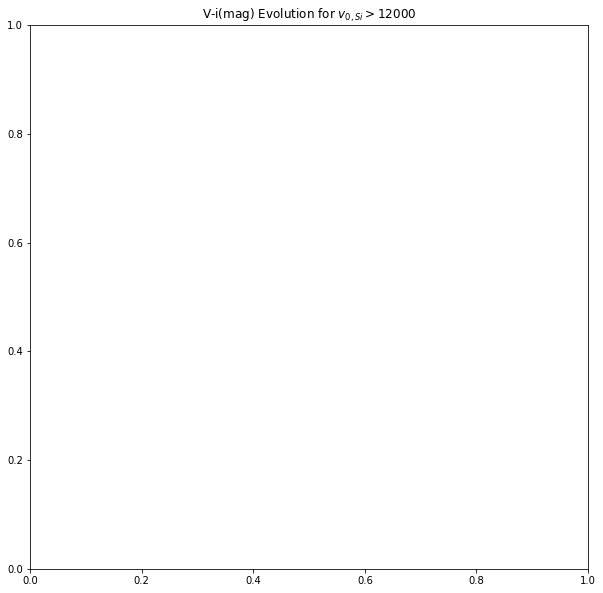

In [10]:
plt.figure(figsize = (10,10))
plt.title("V-i(mag) Evolution for $v_{0, Si} > 12000$")
#plt.xlim((3000,9500))
#plt.ylim((6.5,22))
#plt.yticks([])
#plt.tick_params(axis='y',which='both', bottom=False, top=False)
    
new_composites_phases, new_composites_V, new_composites_i, new_composites_errors = [np.asarray(data) for data in sa.measure_comp_1m2(new_composites, filts = ['GROUND_JOHNSON_V','SDSS_i'])]

plt.plot(new_composites_phases, new_composites_V-new_composites_i, 'gd')

In [ ]:
plt.figure(figsize = (10,10))
plt.title("B-V(mag) Evolution for $v_{0, Si} > 12000$")
#plt.xlim((3000,9500))
#plt.ylim((6.5,22))
#plt.yticks([])
#plt.tick_params(axis='y',which='both', bottom=False, top=False)
    
new_composites_phases, new_composites_B, new_composites_V, new_composites_errors = [np.asarray(data) for data in sa.measure_comp_1m2(new_composites)]

plt.plot(new_composites_phases, new_composites_B-new_composites_V, 'bd')

In [33]:
def timeseries(query, title, colorcurves=True, boot=False):
    
    ###### Creating the Composites ######
    Spectra = composite.grab(query, multi_epoch = True, make_corr = True, selection = "max_coverage")
    Sorted_Spectra = phase_sort(Spectra)
    
    bins = dm15_arrange1(Sorted_Spectra)
    
    Composite_Spectra = []
    
    Time_Series = []
    Time_Series_boots = []
    
    ##################################################################################################################
    
    if boot == False:
    
        for bin in bins:
            comp_spectrum = make_composite(bin)
            dm15 = np.mean(comp_spectrum.dm15_array[comp_spectrum.x1:comp_spectrum.x2])

            Time_Series.append(comp_spectrum)

        ###### Plotting the Time Series ######
        plt.figure(figsize = (11,10))
        plt.title(title + " Time Series")
        plt.xlabel("Rest Wavelength ($\mathrm{\AA}$)", fontsize=14)
        plt.ylabel("Relative Flux + Constant", fontsize=14)
        plt.yticks([])
        #plt.tick_params(
            #axis='y',          # changes apply to the x-axis
            #which='both',      # both major and minor ticks are affected
            #bottom=False,      # ticks along the bottom edge are off
            #top=False,         # ticks along the top edge are off
            #labelbottom=False) # labels along the bottom edge are off
        plt.xlim(3300, 12250)
        
        offset = 10*len(Time_Series)
        for n in range(len(Time_Series)):
            phase = np.mean(Time_Series[n].phase_array[Time_Series[n].x1:Time_Series[n].x2])
            dm15 = np.mean(Time_Series[n].dm15_array[Time_Series[n].x1:Time_Series[n].x2])

            plt.plot(Time_Series[n].wavelength[Time_Series[n].x1:Time_Series[n].x2], 
                     5 * Time_Series[n].flux[Time_Series[n].x1:Time_Series[n].x2] + offset, color='royalblue', linewidth=3)

            plt.text(10750, offset, "{:0.1f}".format(phase) + " Days / " + "{:0.2f}".format(dm15))

            offset-=5
        
        #return Time_Series
        ###### Color Curves ######
        if colorcurves == True:
            # B-V
            plt.figure(figsize = (10,10))
            plt.title("B-V(mag) Evolution for " + title)
            plt.xlabel("Days since Max Light")
            plt.xlim(-20,70)

            Time_Series_phases_BV, Time_Series_B, Time_Series_V, Time_Series_errors = [np.asarray(data) for data in sa.measure_comp_1m2(Time_Series)]

            plt.plot(Time_Series_phases_BV, Time_Series_B-Time_Series_V, 'bd')

            # V-i
            plt.figure(figsize = (10,10))
            plt.title("V-i(mag) Evolution for " + title)
            plt.xlabel("Days since Max Light")
            plt.xlim(-20,70)
            
            Time_Series_phases_Vi, Time_Series_V, Time_Series_i, Time_Series_errors = [np.asarray(data) for data in sa.measure_comp_1m2(Time_Series, filts = ['GROUND_JOHNSON_V','SDSS_i'])]

            plt.plot(Time_Series_phases_Vi, Time_Series_V-Time_Series_i, 'gd')
            
            return Time_Series_B, Time_Series_V, Time_Series_i, Time_Series_phases_BV, Time_Series_phases_Vi
        
  ######################################################################################################################  
    
    elif boot == True:
        
        for bin in bins:
            comp_spectrum, boot_array = make_composite(bin, boot)
            dm15 = np.mean(comp_spectrum.dm15_array[comp_spectrum.x1:comp_spectrum.x2])

            Time_Series.append(comp_spectrum)
            Time_Series_boots.append(boot_array)
            
         ###### Plotting the Time Series ######
        plt.figure(figsize = (10,10))
        plt.title(title + " Time Series")

        offset = 10*len(Time_Series)
        for n in range(len(Time_Series)):
            phase = np.mean(Time_Series[n].phase_array[Time_Series[n].x1:Time_Series[n].x2])
            dm15 = np.mean(Time_Series[n].dm15_array[Time_Series[n].x1:Time_Series[n].x2])

            plt.plot(Time_Series[n].wavelength[Time_Series[n].x1:Time_Series[n].x2], 
                     Time_Series[n].flux[Time_Series[n].x1:Time_Series[n].x2] + offset, color='red')

            plt.text(9500, offset+3, "{:0.1f}".format(phase) + " Days / " + "{:0.2f}".format(dm15))

            offset-=5
        
        ###### Color Curves ######
        if colorcurves == True:
            # B-V
            plt.figure(figsize = (10,10))
            plt.title("B-V(mag) Evolution for " + title)
            plt.xlabel("Days since Max Light")

            Time_Series_phases_BV, Time_Series_B, Time_Series_V, Time_Series_errors_BV = [np.asarray(data) for data in sa.measure_comp_1m2(Time_Series, boot_arrs=Time_Series_boots, error=True)]

            plt.plot(Time_Series_phases_BV, Time_Series_B-Time_Series_V, 'bd')
            plt.errorbar(Time_Series_phases_BV, Time_Series_B-Time_Series_V, yerr=Time_Series_errors_BV, color='blue', fmt='o')
            plt.xlim(-20,70)
            
            # V-i
            plt.figure(figsize = (10,10))
            plt.title("V-i(mag) Evolution for " + title)
            plt.xlabel("Days since Max Light")
            plt.xlim(-20,70)
            
            Time_Series_phases_Vi, Time_Series_V, Time_Series_i, Time_Series_errors_Vi = [np.asarray(data) for data in sa.measure_comp_1m2(Time_Series, filts = ['GROUND_JOHNSON_V','SDSS_i'], boot_arrs=Time_Series_boots, error=True)]

            plt.plot(Time_Series_phases_Vi, Time_Series_V-Time_Series_i, 'gd')
            plt.errorbar(Time_Series_phases_Vi, Time_Series_V-Time_Series_i, yerr=Time_Series_errors_Vi, color='green', fmt='o')
            
            return Time_Series_B, Time_Series_V, Time_Series_i, Time_Series_phases_BV, Time_Series_phases_Vi, Time_Series_errors_BV, Time_Series_errors_Vi

In [65]:
def timeseries_arrays(query, boot=False, make_corr=True):
    
    ###### Creating the Composites ######
    Spectra = composite.grab(query, multi_epoch = True, make_corr = True, selection = "max_coverage")
    Sorted_Spectra = phase_sort(Spectra)
    
    bins = dm15_arrange1(Sorted_Spectra)
    
    Composite_Spectra = []
    
    Time_Series = []
    Time_Series_boots = []
    
    ##################################################################################################################
    
    if boot == False:
    
        for bin in bins:
            comp_spectrum = make_composite(bin, make_corr=make_corr)
            dm15 = np.mean(comp_spectrum.dm15_array[comp_spectrum.x1:comp_spectrum.x2])

            Time_Series.append(comp_spectrum)

        ###### Plotting the Time Series ######
        """plt.figure(figsize = (11,10))
        plt.title(title + " Time Series")
        plt.xlabel("Rest Wavelength ($\mathrm{\AA}$)", fontsize=14)
        plt.ylabel("Relative Flux + Constant", fontsize=14)
        plt.yticks([])
        #plt.tick_params(
            #axis='y',          # changes apply to the x-axis
            #which='both',      # both major and minor ticks are affected
            #bottom=False,      # ticks along the bottom edge are off
            #top=False,         # ticks along the top edge are off
            #labelbottom=False) # labels along the bottom edge are off
        plt.xlim(3300, 12250)"""
        
        x_arrays = []
        y_arrays = []
        
        wavelength_arrays=  []
        flux_arrays = []
        
        offset = 10*len(Time_Series)
        for n in range(len(Time_Series)):
            phase = np.mean(Time_Series[n].phase_array[Time_Series[n].x1:Time_Series[n].x2])
            dm15 = np.mean(Time_Series[n].dm15_array[Time_Series[n].x1:Time_Series[n].x2])

            #plt.plot(Time_Series[n].wavelength[Time_Series[n].x1:Time_Series[n].x2], 
                     #5 * Time_Series[n].flux[Time_Series[n].x1:Time_Series[n].x2] + offset, color='royalblue', linewidth=3)

            #plt.text(10750, offset, "{:0.1f}".format(phase) + " Days / " + "{:0.2f}".format(dm15))

            offset-=5
            
            x_arrays.append(Time_Series[n].wavelength[Time_Series[n].x1:Time_Series[n].x2])
            y_arrays.append(5*Time_Series[n].flux[Time_Series[n].x1:Time_Series[n].x2] + offset)
            
            wavelength_arrays.append(Time_Series[n].wavelength)
            flux_arrays.append(Time_Series[n].flux)
        
        return x_arrays, y_arrays, wavelength_arrays, flux_arrays
            

579 Total Spectra found
8 flagged spectra removed 571 spectra left
0 spectra of peculiar Ias removed 571 spectra left
571 spectra of SNe that have host reddening corrections
Arrays cleaned
original 6 15
original 14 31
original 17 37
original 14 28
original 19 26
original 10 15
original 12 13
original 17 29
original 24 40
original 27 36
original 32 77
original 26 56
original 23 41
original 23 37
original 18 33
original 21 38
original 13 19
6 total SNe
Gini balancing...
Balanced after 4 iterations
Bootstrapping
scaling boots...
computing confidence intervals...
14 total SNe
Gini balancing...
Balanced after 3 iterations
Bootstrapping
scaling boots...
computing confidence intervals...
17 total SNe
Gini balancing...
Balanced after 10 iterations
Bootstrapping
scaling boots...
computing confidence intervals...
14 total SNe
Gini balancing...
Balanced after 7 iterations
Bootstrapping
scaling boots...
computing confidence intervals...
19 total SNe
Gini balancing...
Balanced after 8 iterations
Bo

Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]


771 Total Spectra found
21 flagged spectra removed 750 spectra left
0 spectra of peculiar Ias removed 750 spectra left
750 spectra of SNe that have host reddening corrections
Arrays cleaned
original 16 42
original 24 53
original 35 82
original 39 82
original 24 31
original 20 26
original 27 39
original 24 35
original 23 33
original 29 62
original 30 57
original 27 49
original 30 51
original 30 56
original 20 43
original 7 9
16 total SNe
Gini balancing...
Balanced after 5 iterations
Bootstrapping
scaling boots...
computing confidence intervals...
24 total SNe
Gini balancing...
Balanced after 14 iterations
Bootstrapping
scaling boots...
computing confidence intervals...
35 total SNe
Gini balancing...
Balanced after 15 iterations
Bootstrapping
scaling boots...
computing confidence intervals...
39 total SNe
Gini balancing...
Balanced after 17 iterations
Bootstrapping
scaling boots...
computing confidence intervals...
24 total SNe
Gini balancing...
Balanced after 9 iterations
Bootstrapping


Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]
Hi [0 0 0 ... 0 0 0]


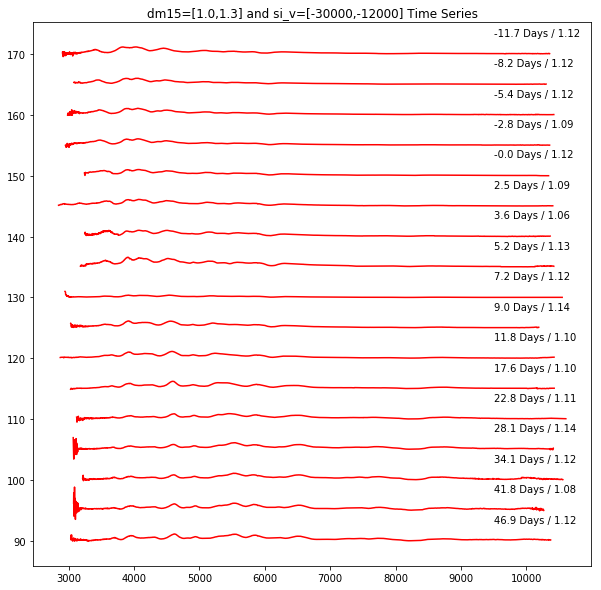

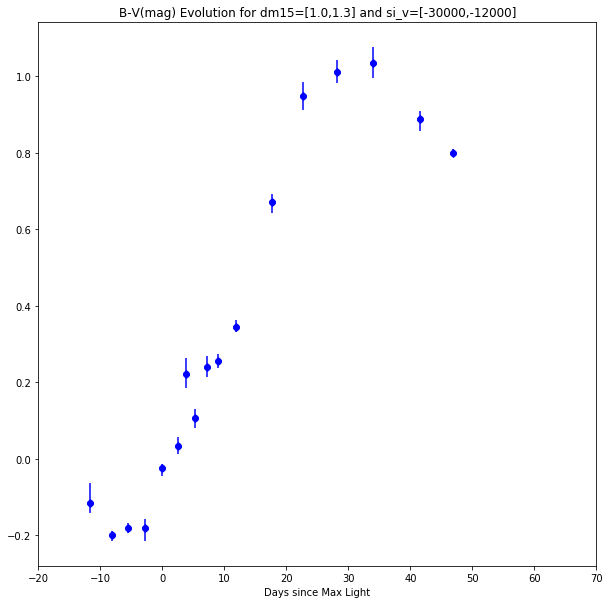

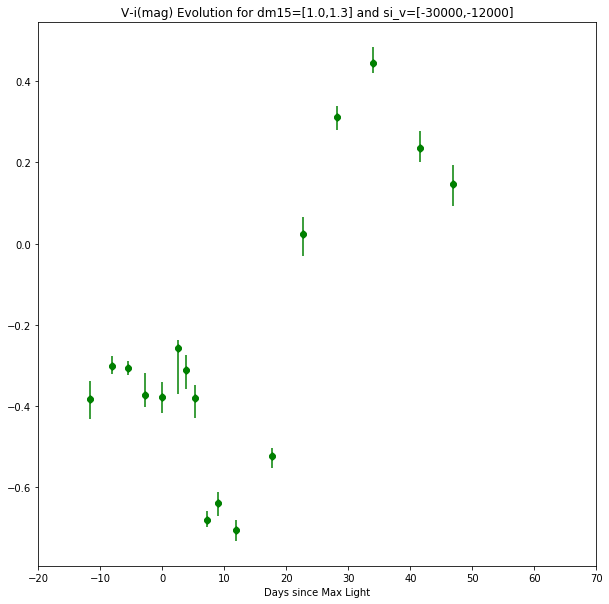

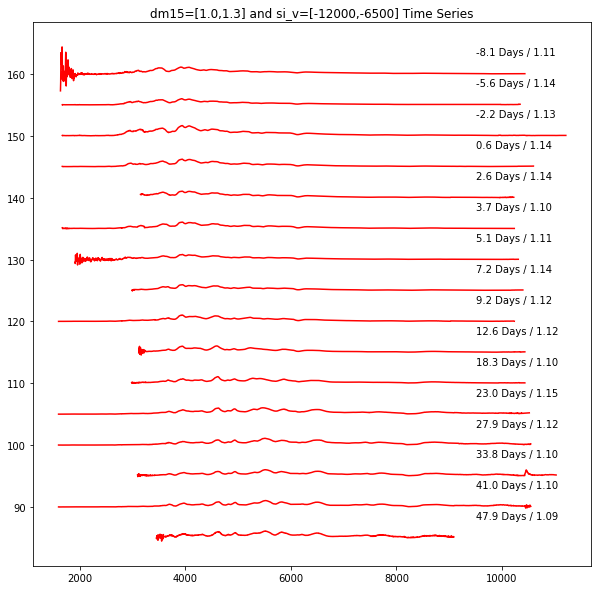

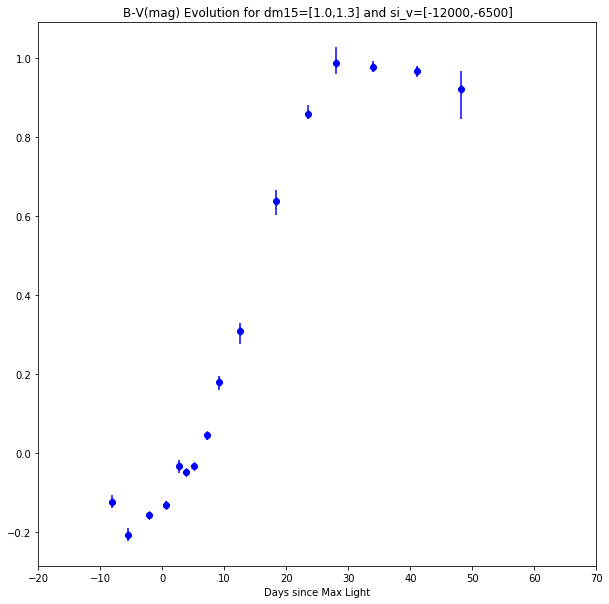

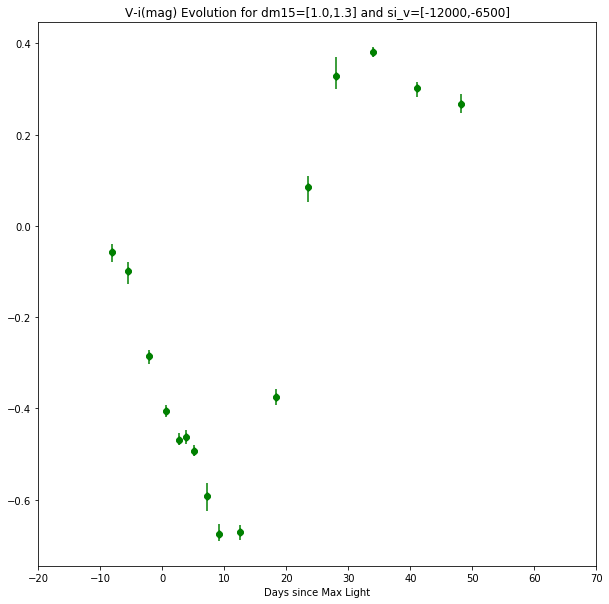

In [42]:
lowv_data = timeseries("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 50. and ((dm15_source >= 1.0 and dm15_source < 1.3) or (dm15_from_fits >= 1.0 and dm15_from_fits < 1.3)) and (si_v0 between -30000 and -12000)",
            "dm15=[1.0,1.3] and si_v=[-30000,-12000]", 
            boot=True)

highv_data = timeseries("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 50. and phase > -10. and ((dm15_source >= 1.0 and dm15_source < 1.3) or (dm15_from_fits >= 1.0 and dm15_from_fits < 1.3)) and (si_v0 between -12000 and -6500)",
           "dm15=[1.0,1.3] and si_v=[-12000,-6500]", 
            boot=True)

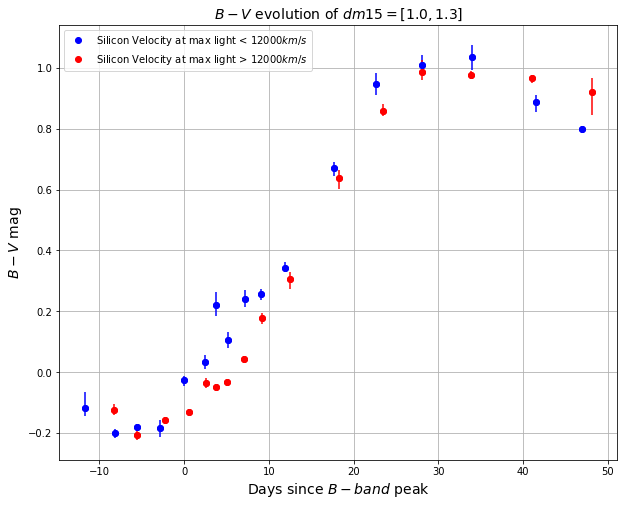

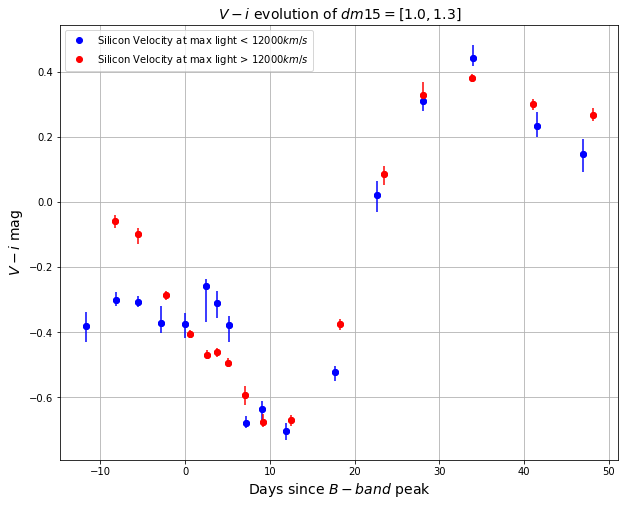

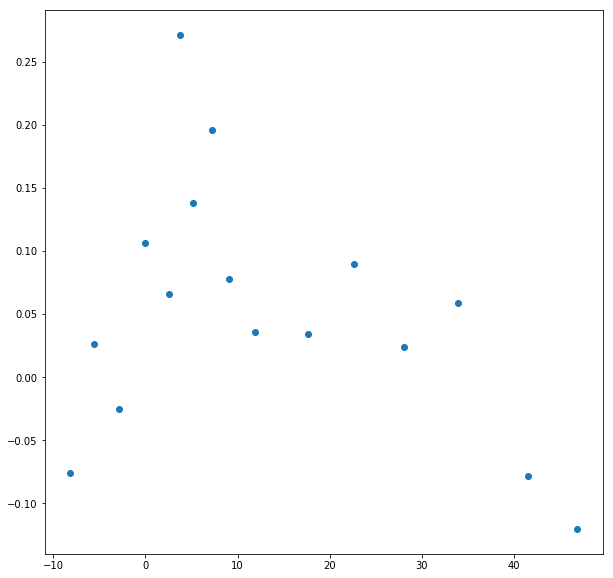

In [77]:
lowv_BV = lowv_data[0]-lowv_data[1]
highv_BV = highv_data[0]-highv_data[1]

lowv_Vi = lowv_data[1]-lowv_data[2]
highv_Vi = highv_data[1]-highv_data[2]

lowv_BV_phases= lowv_data[3]
highv_BV_phases= highv_data[3]

lowv_Vi_phases= lowv_data[4]
highv_Vi_phases= highv_data[4]

lowv_BV_errors = lowv_data[5]
highv_BV_errors = highv_data[5]

lowv_Vi_errors = lowv_data[6]
highv_Vi_errors = highv_data[6]


plt.figure(figsize=(10,8))
plt.title("$B-V$ evolution of $dm15=[1.0,1.3]$", fontsize=14)
plt.ylabel("$B - V$ mag", fontsize=14)
plt.xlabel("Days since $B-band$ peak", fontsize=14)
plt.grid()

plt.plot(lowv_BV_phases, lowv_BV, 'o',color='blue',label="Silicon Velocity at max light < $12000 km/s$")
plt.errorbar(lowv_BV_phases, lowv_BV, yerr=lowv_BV_errors, color='blue', fmt='o')

plt.plot(highv_BV_phases, highv_BV, 'o', color='red', label="Silicon Velocity at max light > $12000 km/s$")
plt.errorbar(highv_BV_phases, highv_BV, yerr=highv_BV_errors, color='red', fmt='o')
plt.legend()



plt.figure(figsize=(10,8))
plt.title("$V-i$ evolution of $dm15=[1.0,1.3]$", fontsize=14)
plt.ylabel("$V - i$ mag", fontsize=14)
plt.xlabel("Days since $B-band$ peak", fontsize=14)
plt.grid()

plt.plot(lowv_Vi_phases, lowv_Vi, 'o',color='blue', label="Silicon Velocity at max light < $12000 km/s$")
plt.errorbar(lowv_Vi_phases, lowv_Vi, yerr=lowv_Vi_errors, color='blue', fmt='o')

plt.plot(highv_Vi_phases, highv_Vi, 'o', color='red', label="Silicon Velocity at max light > $12000 km/s$")
plt.errorbar(highv_Vi_phases, highv_Vi, yerr=highv_Vi_errors, color='red', fmt='o')
plt.legend()


plt.figure(figsize=(10,10))
plt.plot(lowv_BV_phases[1:], lowv_BV[1:]-highv_BV, "o")

# Middle dm15


579 Total Spectra found
8 flagged spectra removed 571 spectra left
0 spectra of peculiar Ias removed 571 spectra left
571 spectra of SNe that have host reddening corrections
Arrays cleaned
original 6 15
original 14 31
original 17 37
original 14 28
original 19 26
original 10 15
original 12 13
original 17 29
original 24 40
original 27 36
original 32 77
original 26 56
original 23 41
original 23 37
original 18 33
original 21 38
original 13 19
6 total SNe
Gini balancing...
Balanced after 4 iterations
14 total SNe
Gini balancing...
Balanced after 3 iterations
17 total SNe
Gini balancing...
Balanced after 10 iterations
14 total SNe
Gini balancing...
Balanced after 7 iterations
19 total SNe
Gini balancing...
Balanced after 8 iterations
10 total SNe
Gini balancing...
Balanced after 5 iterations
12 total SNe
Gini balancing...
Balanced after 10 iterations
17 total SNe
Gini balancing...
Balanced after 9 iterations
24 total SNe
Gini balancing...
Balanced after 10 iterations
27 total SNe
Gini balanc

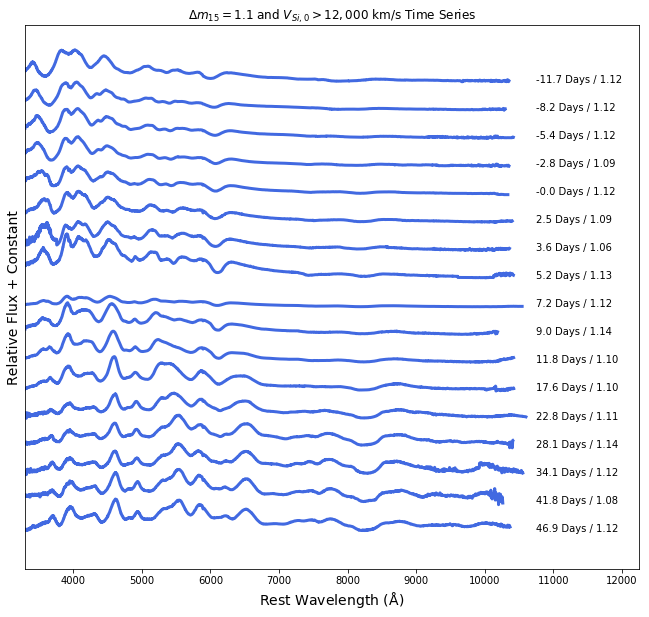

In [73]:
timeseries("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 50. and ((dm15_source >= 1.0 and dm15_source < 1.3) or (dm15_from_fits >= 1.0 and dm15_from_fits < 1.3)) and (si_v0 between -30000 and -12000)",
            "$\Delta m_{15}=1.1$ and $V_{Si, 0}>12,000$ km/s", 
           colorcurves=False, 
           boot=False)

771 Total Spectra found
21 flagged spectra removed 750 spectra left
0 spectra of peculiar Ias removed 750 spectra left
750 spectra of SNe that have host reddening corrections
Arrays cleaned
original 16 42
original 24 53
original 35 82
original 39 82
original 24 31
original 20 26
original 27 39
original 24 35
original 23 33
original 29 62
original 30 57
original 27 49
original 30 51
original 30 56
original 20 43
original 7 9
16 total SNe
Gini balancing...
Balanced after 5 iterations
24 total SNe
Gini balancing...
Balanced after 14 iterations
35 total SNe
Gini balancing...
Balanced after 15 iterations
39 total SNe
Gini balancing...
Balanced after 17 iterations
24 total SNe
Gini balancing...
Balanced after 9 iterations
20 total SNe
Gini balancing...
Balanced after 13 iterations
27 total SNe
Gini balancing...
Balanced after 10 iterations
24 total SNe
Gini balancing...
Balanced after 10 iterations
23 total SNe
Gini balancing...
Balanced after 13 iterations
29 total SNe
Gini balancing...
Bal

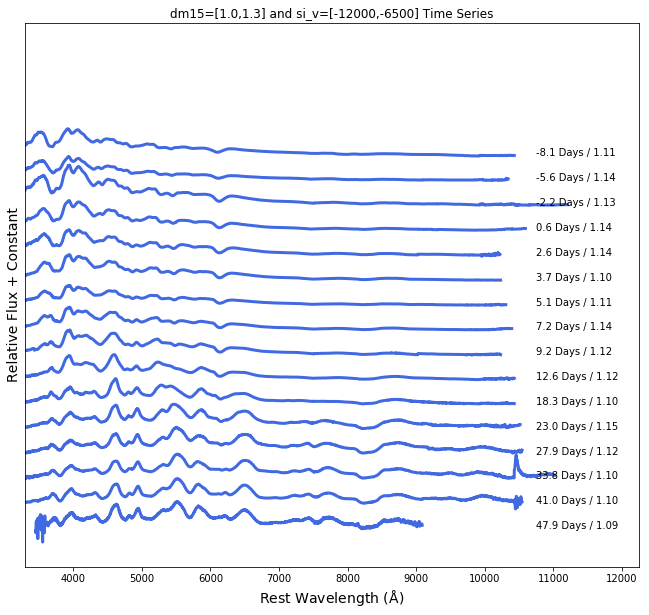

In [74]:
timeseries("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 50. and phase > -10. and ((dm15_source >= 1.0 and dm15_source < 1.3) or (dm15_from_fits >= 1.0 and dm15_from_fits < 1.3)) and (si_v0 between -12000 and -6500)",
           "dm15=[1.0,1.3] and si_v=[-12000,-6500]", 
            boot=False, colorcurves=False)

# High dm15

233 Total Spectra found
11 flagged spectra removed 222 spectra left
0 spectra of peculiar Ias removed 222 spectra left
222 spectra of SNe that have host reddening corrections
Arrays cleaned
original 2 10
expanded 3 18
not enough data (3) between -9.02117356738 and -3.02117356738 days.
original 7 14
original 5 6
original 5 6
original 16 25
original 12 21
original 14 20
original 17 35
original 9 15
original 11 14
original 9 12
original 11 21
original 6 10
original 2 2
expanded 5 5
7 total SNe
Gini balancing...
Balanced after 4 iterations
5 total SNe
Gini balancing...
Balanced after 8 iterations
5 total SNe
Gini balancing...
Balanced after 1 iterations
16 total SNe
Gini balancing...
Balanced after 2 iterations
12 total SNe
Gini balancing...
Balanced after 14 iterations
14 total SNe
Gini balancing...
Balanced after 4 iterations
17 total SNe
Gini balancing...
Balanced after 4 iterations
9 total SNe
Gini balancing...
Balanced after 2 iterations
11 total SNe
Gini balancing...
Balanced after 1

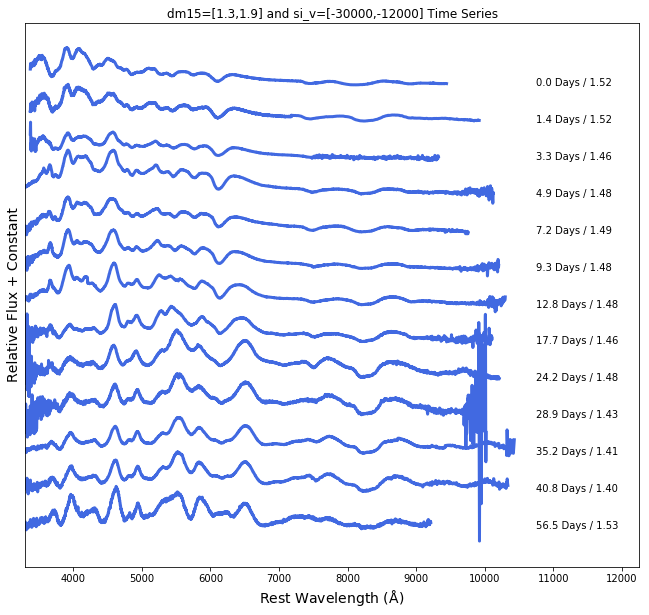

In [75]:
timeseries("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 60. and ((dm15_source >= 1.3 and dm15_source < 1.9) or (dm15_from_fits >= 1.3 and dm15_from_fits < 1.9)) and (si_v0 between -30000 and -12000)",
            "dm15=[1.3,1.9] and si_v=[-30000,-12000]", 
            boot=False, colorcurves=False)

In [ ]:
timeseries("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 87. and ((dm15_source >= 1.3 and dm15_source < 1.9) or (dm15_from_fits >= 1.3 and dm15_from_fits < 1.9)) and (si_v0 between -12000 and -6500)",
           "dm15=[1.3,1.9] and si_v=[-12000,-6500]", 
            boot=True)

# Low dm15

In [ ]:
timeseries("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 60. and ((dm15_source >= 0.85 and dm15_source < 1.0) or (dm15_from_fits >= 0.85 and dm15_from_fits < 1.0)) and (si_v0 between -12000 and -6500)",
            "dm15=[0.85,1.0] and si_v=[-12000,-6500]", 
            boot=True)

# Bump Analysis

In [ ]:
high_v = timeseries("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 50. and ((dm15_source >= 1.0 and dm15_source < 1.3) or (dm15_from_fits >= 1.0 and dm15_from_fits < 1.3)) and (si_v0 between -30000 and -12000)",
            "dm15=[1.0,1.3] and si_v=[-30000,-12000]", 
            colorcurves=False, boot=False)

low_v = timeseries("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 50. and ((dm15_source >= 1.0 and dm15_source < 1.3) or (dm15_from_fits >= 1.0 and dm15_from_fits < 1.3)) and (si_v0 between -12000 and -6500)",
            "dm15=[1.0,1.3] and si_v=[-12000,-6500]", 
            colorcurves=False, boot=False)

In [ ]:
plt.figure(figsize = (8,10))
plt.title("mid dm15 times series highv/lowv")

plt.xlim(2500, 7500)
offset = 10*len(high_v)

plt.axvline(4000, color='cyan')
plt.axvline(5000, color='black')
plt.axvline(7000, color='green')

for n in range(len(high_v)):
            high_v_phase = np.mean(high_v[n].phase_array[high_v[n].x1:high_v[n].x2])
            low_v_phase = np.mean(low_v[n].phase_array[low_v[n].x1:low_v[n].x2])
            
            plt.text(7050, offset+5, "{:0.1f}".format(high_v_phase) + " / " + "{:0.1f}".format(low_v_phase) , fontsize=8)
            
            plt.plot(low_v[n].wavelength[low_v[n].x1:low_v[n].x2], 
                     7 * low_v[n].flux[low_v[n].x1:low_v[n].x2] + offset, color='red')
            
            plt.plot(high_v[n].wavelength[high_v[n].x1:high_v[n].x2], 
                     7 * high_v[n].flux[high_v[n].x1:high_v[n].x2] + offset, color='blue')


            offset-=10

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(low_v[0].wavelength[low_v[0].x1:low_v[0].x2], 
                     7 * low_v[0].flux[low_v[0].x1:low_v[0].x2] + offset, color='red')
            
plt.plot(high_v[0].wavelength[high_v[0].x1:high_v[0].x2], 
                     7 * high_v[0].flux[high_v[0].x1:high_v[0].x2] + offset, color='blue')

In [ ]:
hphases, hBV, hBV_error = timeseries("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 50. and ((dm15_source >= 1.0 and dm15_source < 1.3) or (dm15_from_fits >= 1.0 and dm15_from_fits < 1.3)) and (si_v0 between -30000 and -12000)",
            "dm15=[1.0,1.3] and si_v=[-30000,-12000]", 
            colorcurves=True, boot=True)

lphases, lBV, lBV_error = timeseries("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 50. and ((dm15_source >= 1.0 and dm15_source < 1.3) or (dm15_from_fits >= 1.0 and dm15_from_fits < 1.3)) and (si_v0 between -12000 and -6500)",
            "dm15=[1.0,1.3] and si_v=[-12000,-6500]", 
            colorcurves=True, boot=True)

In [ ]:
plt.figure(figsize = (10,10))
            
plt.title("B-V(mag) Evolution for dm15 = [1.0,1.3]")
plt.xlabel("Days since Max Light")
plt.grid()


#plt.plot(Time_Series_phases_BV, Time_Series_B-Time_Series_V, 'bd')
plt.errorbar(hphases, hBV, yerr=hBV_error, color='red', fmt='o', label='v0 > 12000')
plt.errorbar(lphases, lBV, yerr=lBV_error, color='blue', fmt='o', label='v0 < 12000')

plt.xlim(-20,70)

plt.legend()

In [ ]:
timeseries("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 20. and phase > -2 and ((dm15_source >= 1.0 and dm15_source < 1.3) or (dm15_from_fits >= 1.0 and dm15_from_fits < 1.3)) and (si_v0 between -30000 and -12000)",
            "dm15=[1.0,1.3] and si_v=[-30000,-12000]", 
            boot=True)

# Matching velocity and x1 to analyze salt_c

11 Total Spectra found
8 spectra of SNe that have host reddening corrections
Arrays cleaned
0.081625


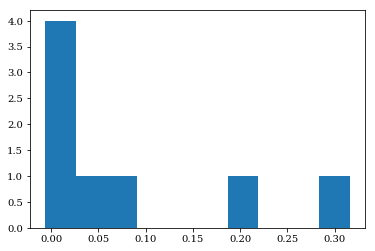

In [169]:
query = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 1 and phase > -1 and (si_v0 between -30000 and -12000) and c_salt"
sn_array = composite.grab(query, multi_epoch = False, make_corr = False, selection = "max_coverage")

plt.hist([object.c_salt for object in sn_array])
print np.mean([object.c_salt for object in sn_array])

51 Total Spectra found
37 spectra of SNe that have host reddening corrections
Arrays cleaned
0.051000000000000004


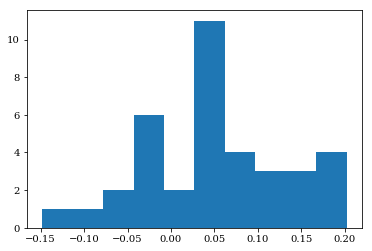

In [170]:
query = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 1 and phase > -1 and (si_v0 between -12000 and -6000) and c_salt"
sn_array = composite.grab(query, multi_epoch = False, make_corr = False, selection = "max_coverage")

plt.hist([object.c_salt for object in sn_array])
print np.mean([object.c_salt for object in sn_array])

# Playing with salt c

In [18]:
c_query = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 1. and phase > -1. and (c_salt between -0.3 and 0.2) and si_v0"
c_sn_array = composite.grab(c_query, multi_epoch = False, make_corr = False, selection = "max_coverage")

59 Total Spectra found
43 spectra of SNe that have host reddening corrections
Arrays cleaned


(array([ 1.,  0.,  3.,  4.,  7., 11.,  6.,  4.,  3.,  4.]),
 array([-0.148 , -0.1143, -0.0806, -0.0469, -0.0132,  0.0205,  0.0542,
         0.0879,  0.1216,  0.1553,  0.189 ]),
 <a list of 10 Patch objects>)

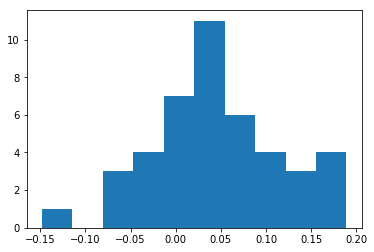

In [19]:
plt.hist([object.c_salt for object in c_sn_array])

In [34]:
c_queries = []
c_ranges = ["< 0", "> 0"]
for i in c_ranges:
    c_query = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 3. and phase > 1. and (c_salt "+ i +") and (si_v0 between -30000 and -6000)"
    c_queries.append(c_query)

In [35]:
c_composites = []
corrected_composites = []
for query in c_queries:
    sn_array = composite.grab(query, multi_epoch = False, make_corr = False, selection = "max_coverage")
    c_composite = make_composite(sn_array, make_corr=False)
    corrected_composite = make_composite(sn_array, make_corr=True)
    
    c_composites.append(c_composite)
    corrected_composites.append(corrected_composite)

13 Total Spectra found
7 spectra of SNe that have host reddening corrections
Arrays cleaned
7 total SNe
Gini balancing...
Balanced after 6 iterations
7 total SNe
Gini balancing...
Balanced after 6 iterations
56 Total Spectra found
37 spectra of SNe that have host reddening corrections
Arrays cleaned
37 total SNe
Gini balancing...
Balanced after 11 iterations
37 total SNe
Gini balancing...
Balanced after 11 iterations


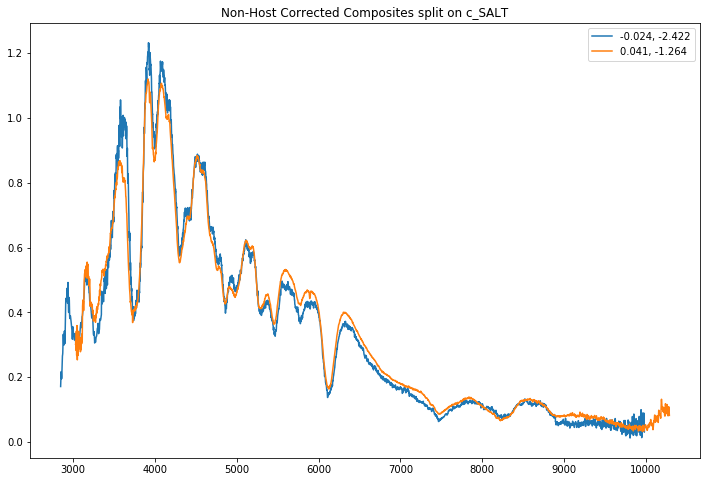

In [36]:
plt.figure(figsize=(12,8))
plt.title('Non-Host Corrected Composites split on c_SALT')
for spectrum in c_composites:
    plt.plot(spectrum.wavelength[spectrum.x1:spectrum.x2], spectrum.flux[spectrum.x1:spectrum.x2], label=str(spectrum.c_salt2)+", "+str(spectrum.x1_salt2))
plt.legend()

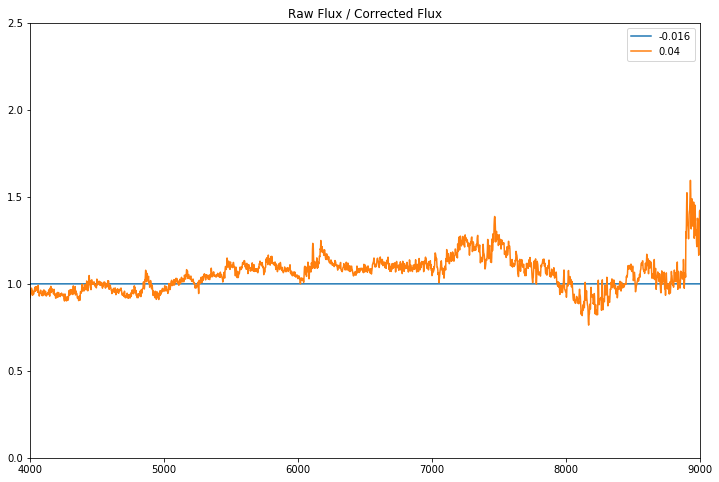

In [37]:
plt.figure(figsize=(12,8))
plt.title('Raw Flux / Corrected Flux')
plt.xlim(4000,9000)
plt.ylim(0, 2.5)
for i in range(len(c_composites)):
    wavelength = c_composites[i].wavelength[c_composites[0].x1:c_composites[0].x2]
    flux = c_composites[i].flux[c_composites[0].x1:c_composites[0].x2] /  c_composites[0].flux[c_composites[0].x1:c_composites[0].x2]
    
    
    plt.plot(wavelength,flux , label=str(c_composites[i].c_salt))
plt.legend()

#c_composites_phases, c_composites_B, c_composites_V = [np.asarray(data) for data in sa.measure_comp_1m2(c_composites, filts = ['GROUND_JOHNSON_B','GROUND_JOHNSON_V'])]

In [107]:
highc_query = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 20 and (c_salt > 0) and (si_v0 between -30000 and -6000)"
lowc_query = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN and phase < 20 and (c_salt < 0) and (si_v0 between -30000 and -6000)"

In [108]:
hc_x, hc_y, hc_wave, hc_flux = timeseries_arrays(highc_query, make_corr=False)
lc_x, lc_y, lc_wave, lc_flux = timeseries_arrays(lowc_query, make_corr=False)

533 Total Spectra found
14 flagged spectra removed 519 spectra left
0 spectra of peculiar Ias removed 519 spectra left
519 spectra of SNe that have host reddening corrections
Arrays cleaned
original 16 27
original 23 40
original 31 57
original 39 65
original 26 28
original 24 30
original 27 28
original 33 42
original 38 57
original 24 30
original 39 64
original 33 51
16 total SNe
Gini balancing...
Balanced after 5 iterations
23 total SNe
Gini balancing...
Balanced after 3 iterations
31 total SNe
Gini balancing...
Balanced after 6 iterations
39 total SNe
Gini balancing...
Balanced after 15 iterations
26 total SNe
Gini balancing...
Balanced after 7 iterations
24 total SNe
Gini balancing...
Balanced after 5 iterations
27 total SNe
Gini balancing...
Balanced after 9 iterations
33 total SNe
Gini balancing...
Balanced after 4 iterations
38 total SNe
Gini balancing...
Balanced after 11 iterations
24 total SNe
Gini balancing...
Balanced after 3 iterations
39 total SNe
Gini balancing...
Balance

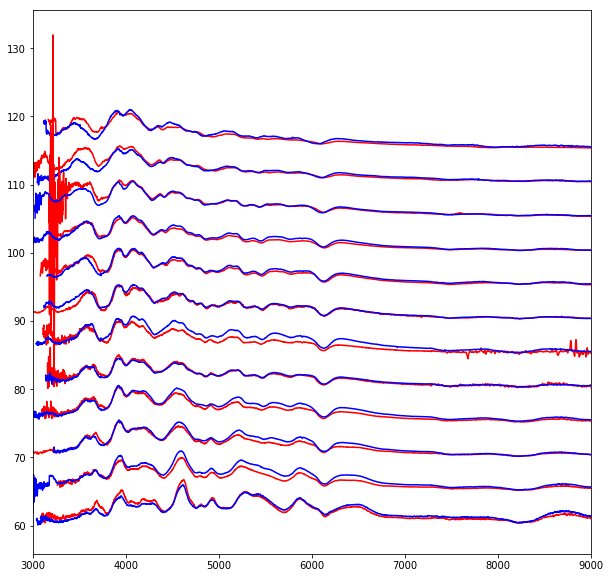

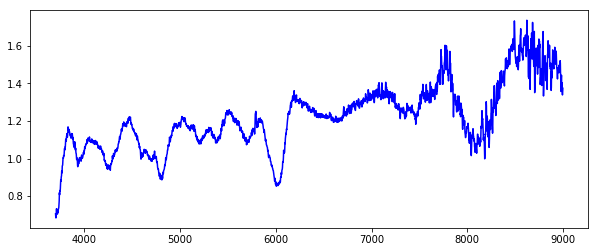

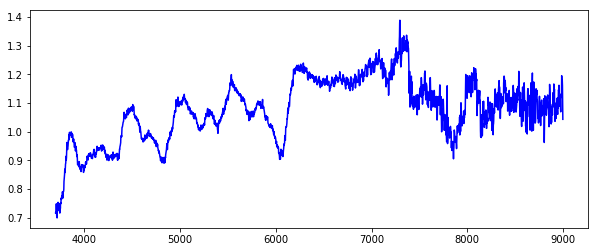

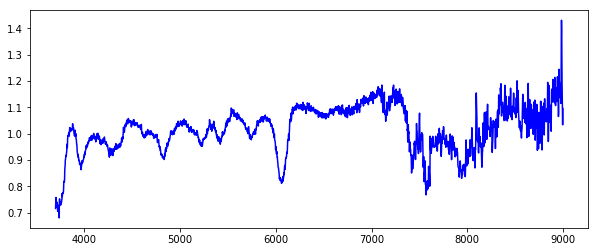

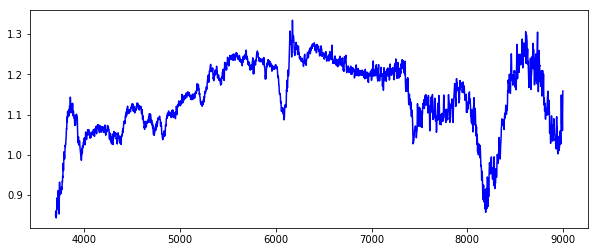

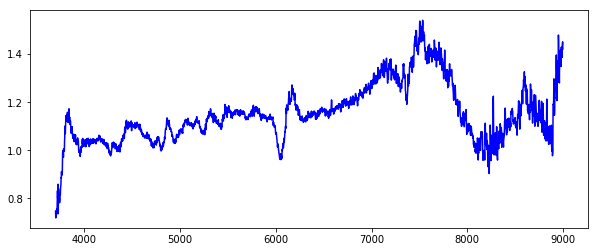

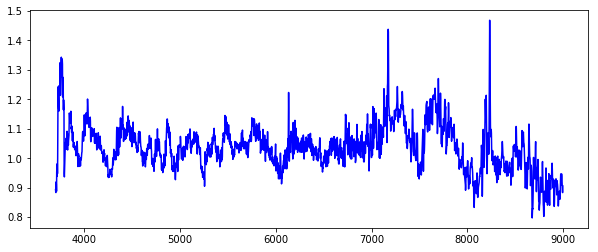

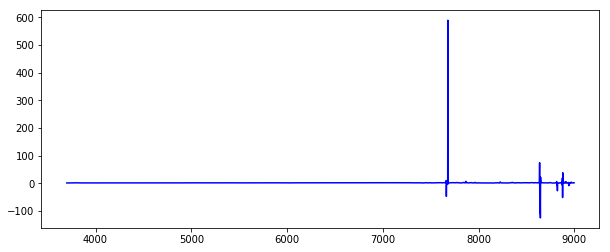

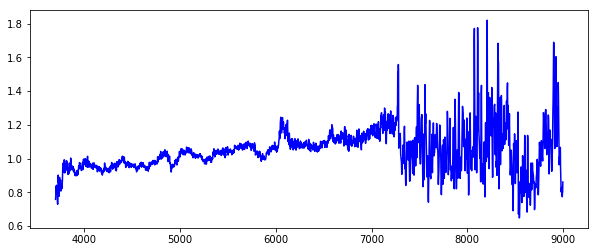

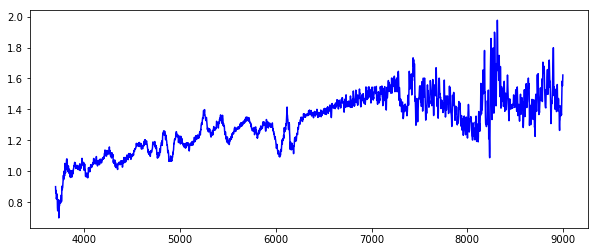

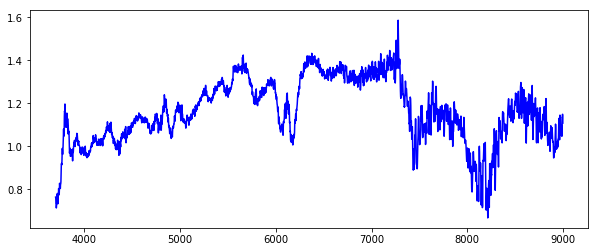

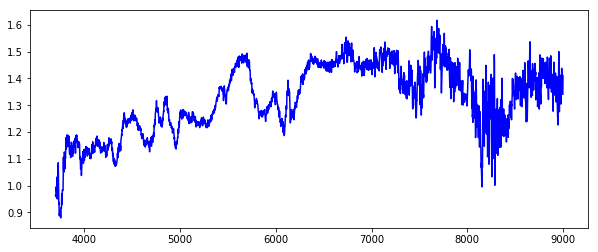

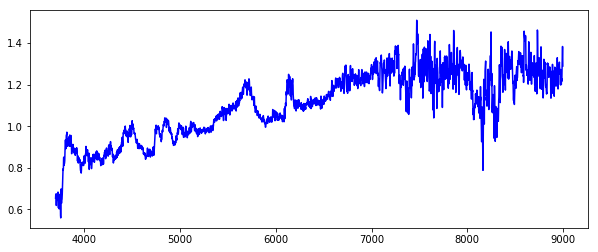

In [109]:
plt.figure(figsize=(10,10))
plt.xlim(3000, 9000)
for i in range(len(lowc_x)):
    plt.plot(lc_x[i],lc_y[i], color='red')
    plt.plot(hc_x[i],hc_y[i], color='blue')
    

for i in range(len(lowc_x)):
    plt.figure(figsize=(10,4))
    plt.plot(hc_wave[i][1350:4000], np.asarray(hc_flux[i])[1350:4000]/np.asarray(lc_flux[i])[1350:4000], color='blue')
    plt.show()

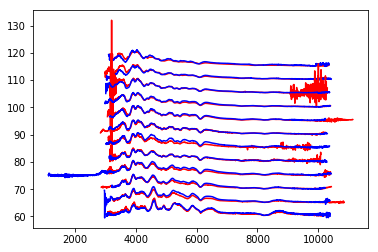

In [110]:
for i in range(len(lowc_x)):
    plt.plot(lc_x[i],lc_y[i], color='red')
    plt.plot(hc_x[i],hc_y[i], color='blue')

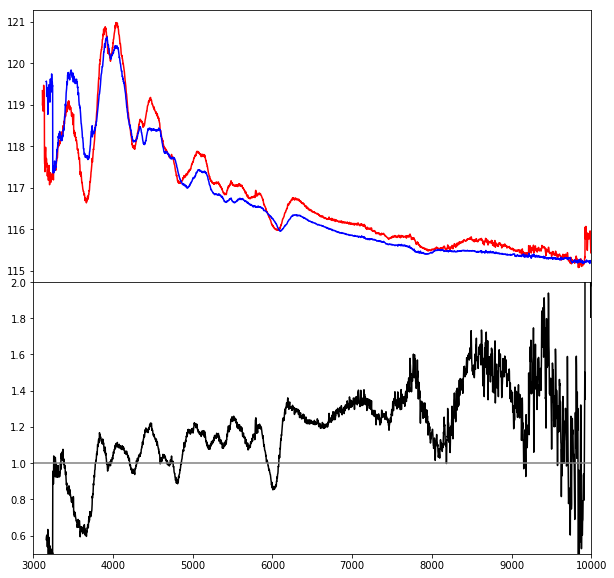

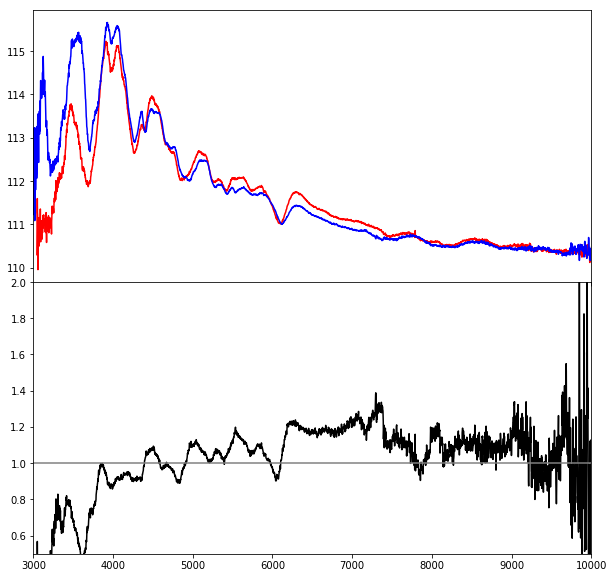

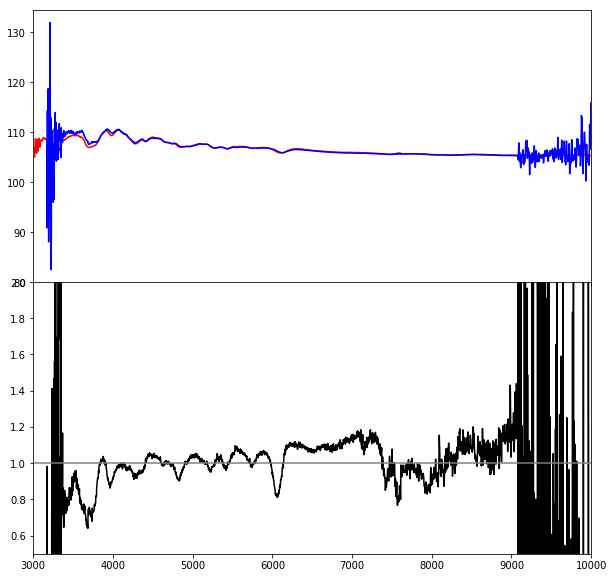

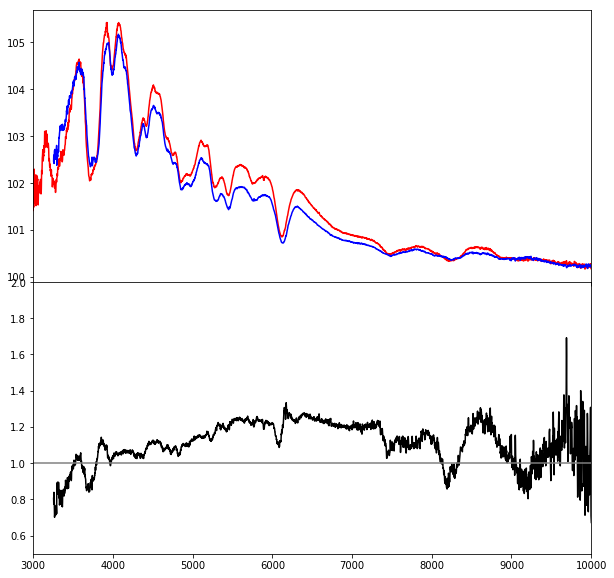

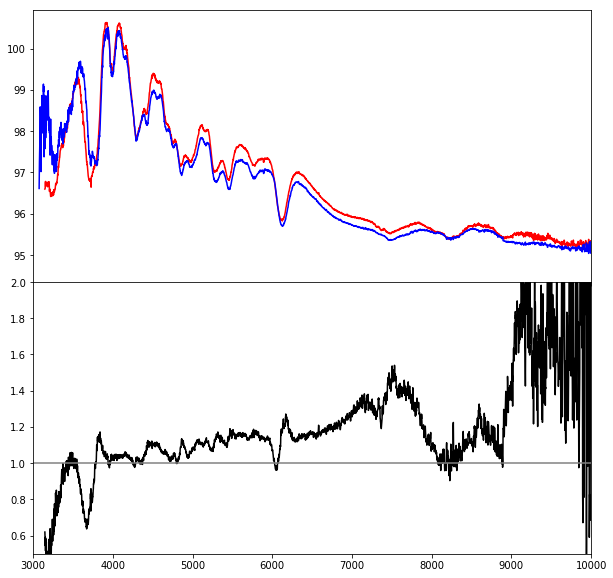

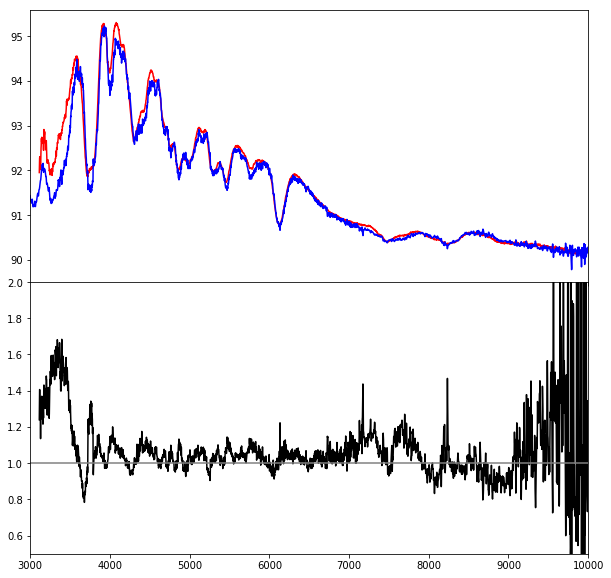

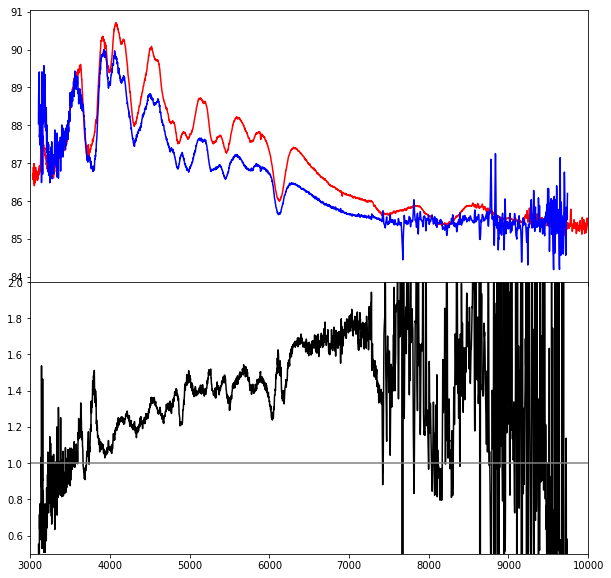

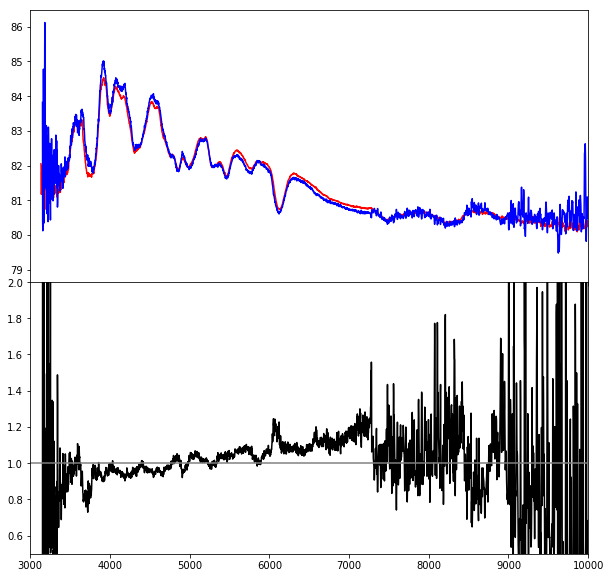

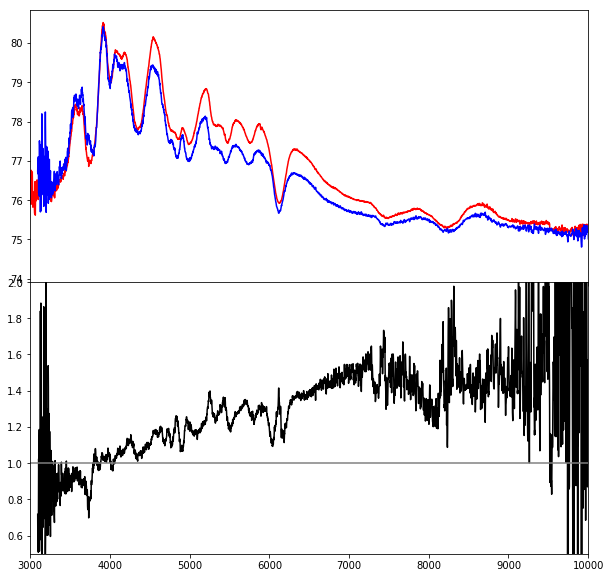

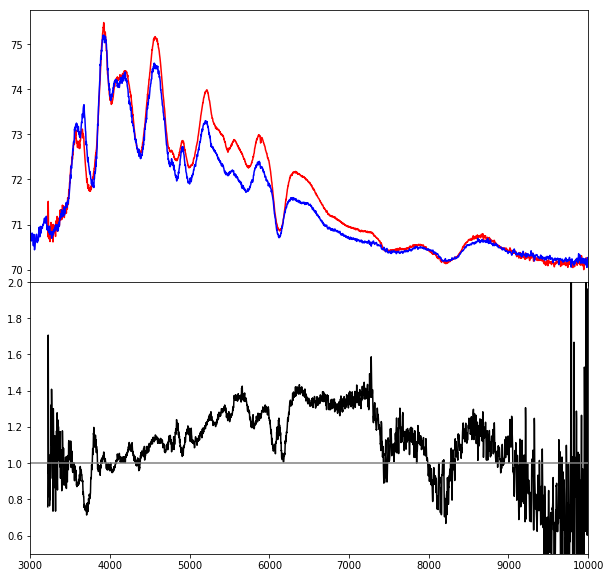

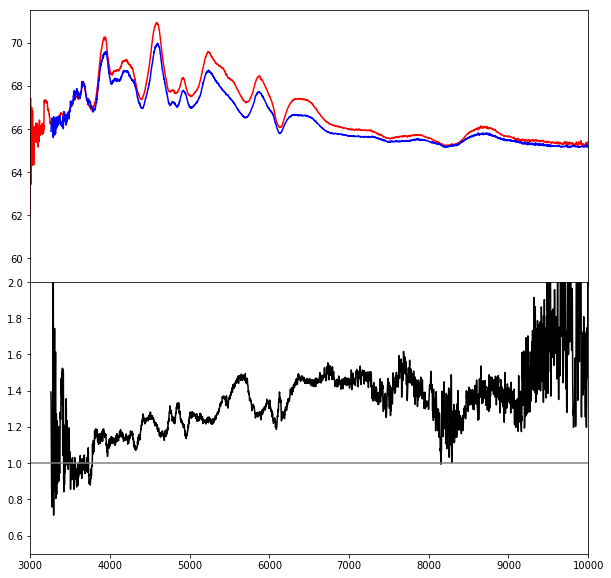

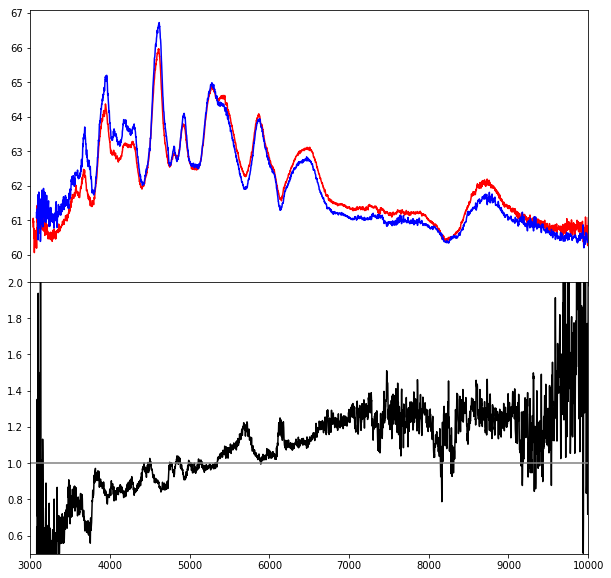

In [111]:
for i in range(len(hc_x)):
    fig = plt.figure(1, figsize=(10,10))
    gs = gridspec.GridSpec(2,1)
    gs.update(wspace=0, hspace=0)

    ax1 = fig.add_subplot(gs[0])
    ax1.set_xticklabels([])
    ax1.set_xlim(3000, 10000)
    ax1.plot(hc_x[i], hc_y[i], color='red')
    ax1.plot(lc_x[i], lc_y[i], color='blue')

    ax2 = fig.add_subplot(gs[1])
    ax2.set_xlim(3000, 10000)
    ax2.set_ylim(0.5, 2)
    ax2.plot(hc_wave[i], hc_flux[i]/lc_flux[i], color='black')
    ax2.axhline(1,color='grey')

    plt.show()